In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
![ ! -f "pip_installed" ] && \
cp /content/drive/MyDrive/TeamSemiSuperCV/Active_Learn/preprocess.py . && \
cp /content/drive/MyDrive/TeamSemiSuperCV/Wing/jet_colors.npy . && \
mkdir /content/model && \
cp -R /content/drive/MyDrive/TeamSemiSuperCV/Stage3_Model/random_2pc/saved_model_keras/37000/* /content/model && \
!touch pip_installed

/bin/bash: !touch: command not found


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from importlib import reload
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input, GlobalMaxPooling2D, Lambda
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Model
from PIL import Image

In [7]:
SSL_MODEL = True
FSL_MODEL = False

if SSL_MODEL:
  IMG_SIZE = (224, 224, 3)
elif FSL_MODEL:
  IMG_SIZE = (256, 256, 3)

In [6]:
def img_preprocess(imgs):
  if SSL_MODEL:
    imgs = tf.image.convert_image_dtype(imgs, dtype=tf.float32)
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bicubic')
    imgs = tf.clip_by_value(imgs, 0.0, 1.0)
  elif FSL_MODEL:
    imgs = tf.image.resize(imgs, IMG_SIZE[:2], method='bicubic')
    imgs = tf.cast(imgs, tf.uint8)
  else:
    raise Exception
  return imgs

In [ ]:
def model_fsl_preprocess(x):
    x = Rescaling(1/255)(x)
    return x

def make_fsl_model(input_shape):
    base_model = ResNet50(include_top=False, pooling=None, weights=None,
                          input_shape=input_shape)
    
    inputs = Input(shape=input_shape)
    x = model_fsl_preprocess(inputs)
    x = base_model(x)
    x = Lambda(lambda x: x, name='lambda_1')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [56]:
if FSL_MODEL:
  model = make_fsl_model(IMG_SIZE)
  # model.load_weights('/content/drive/MyDrive/TeamSemiSuperCV/Wing/FSL_Benchmarks/FSL_ResNet50_XrayReborn.h5')
  model.load_weights('./FSL_ResNet50_XrayReborn.h5')
elif SSL_MODEL: 
  model = tf.keras.models.load_model('model')
  
model.trainable = False
model.build(IMG_SIZE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
img_files = ['BACTERIA-7422-0001.jpeg', 'BACTERIA-30629-0001.jpeg',
             'NORMAL-28501-0001.jpeg', 'NORMAL-32326-0001.jpeg']

((800, 1119, 3), 0, 255)

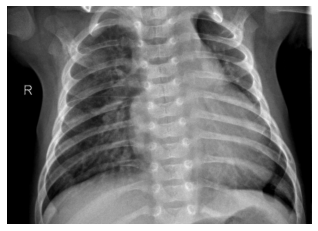

In [46]:
img_idx = 0
fname = img_files[img_idx]
img = np.array(Image.open('static/' + fname))
if len(img.shape) == 2:
    img = np.stack([img] * 3, axis=-1)
plt.axis('off'); plt.imshow(img);
img.shape, img.min(), img.max()

In [57]:
batch = np.expand_dims(img, axis=0)
batch_t = img_preprocess(batch)
if SSL_MODEL:
  pred = tf.nn.softmax(model.predict(batch_t)).numpy()
  print(f'{fname} ==> {pred[0][1]:.3f}')
elif FSL_MODEL:
  pred = model.predict(batch_t)
  print(f'{fname} ==> {pred[0][0]:.3f}')

BACTERIA-7422-0001.jpeg ==> 0.731


In [48]:
# Create Grad-CAM heatmap of single image
def make_gradcam_heatmap(img_batch, model, last_conv_layer, pred_index):
    assert len(img_batch.shape) == 4 and img_batch.shape[0] == 1
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    if isinstance(last_conv_layer, str):
        last_conv_layer = model.get_layer(last_conv_layer)
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer.output, model.output]
    )

    # Grad-CAM requires model's output to be logits
    last_activation = model.layers[-1].activation
    model.layers[-1].activation = None

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_batch)
        if pred_index is None:  # then pick the highest-probability class
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Restore model's output activation
    model.layers[-1].activation = last_activation

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

((7, 7), 0.0, 1.0)

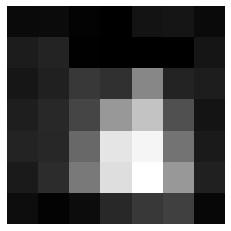

In [58]:
if FSL_MODEL:
  heatmap = make_gradcam_heatmap(batch_t, model, 'lambda_1', 0)
elif SSL_MODEL:
  heatmap = make_gradcam_heatmap(batch_t, model, 'conv5_block3_out', 1)
plt.axis('off'); plt.imshow(heatmap, cmap='gray');
heatmap.shape, heatmap.min(), heatmap.max()

## Grayscale Heatmap

(800, 1119, 3) -0.007004724 1.0109136


(TensorShape([800, 1119, 3]), 0.0, 1.0)

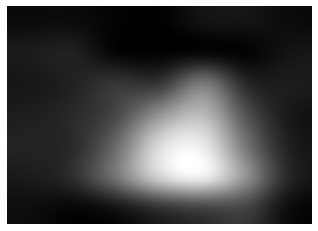

In [59]:
heatmap_rgb = np.stack([heatmap] * 3, axis=-1)
heatmap_rsg = tf.image.resize(heatmap_rgb, img.shape[:2], tf.image.ResizeMethod.MITCHELLCUBIC)
print(heatmap_rsg.shape, tf.reduce_min(heatmap_rsg).numpy(), tf.reduce_max(heatmap_rsg).numpy())
heatmap_rsg = tf.clip_by_value(heatmap_rsg, 0.0, 1.0)
plt.axis('off'); plt.imshow(heatmap_rsg)
heatmap_rsg.shape, tf.reduce_min(heatmap_rsg).numpy(), tf.reduce_max(heatmap_rsg).numpy()

0.05 1.1999999
0.0 278.4


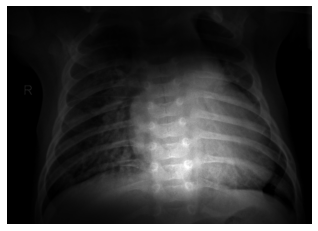

In [60]:
heatmap_rsg = heatmap_rsg * 1.15 + 0.05
print(tf.reduce_min(heatmap_rsg).numpy(), tf.reduce_max(heatmap_rsg).numpy())
superimp_g = heatmap_rsg * img
print(tf.reduce_min(superimp_g).numpy(), tf.reduce_max(superimp_g).numpy())
superimp_g = tf.cast(tf.clip_by_value(superimp_g, 0.0, 255.0), tf.uint8)
tf.io.write_file('saliency-gray.jpeg', tf.io.encode_jpeg(superimp_g))
plt.axis('off'); plt.imshow(superimp_g);

## Color Heatmap

In [61]:
jet_colors = np.load('jet_colors.npy')
jet_colors.shape, jet_colors.min(), jet_colors.max()

((256, 3), 0.0, 1.0)

((7, 7, 3), 0.0, 1.0)

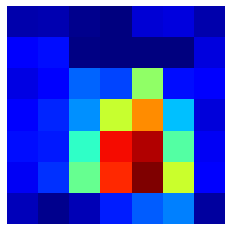

In [62]:
heatmap_ui8 = np.uint8(255 * heatmap)
heatmap_jet = jet_colors[heatmap_ui8]
plt.axis('off'); plt.imshow(heatmap_jet)
heatmap_jet.shape, heatmap_jet.min(), heatmap_jet.max()

(800, 1119, 3) -0.07680192 1.0820315


(TensorShape([800, 1119, 3]), 0.0, 1.0)

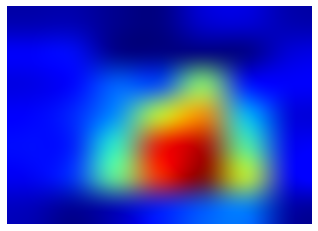

In [63]:
heatmap_rsc = tf.image.resize(heatmap_jet, img.shape[:2], tf.image.ResizeMethod.MITCHELLCUBIC)
print(heatmap_rsc.shape, tf.reduce_min(heatmap_rsc).numpy(), tf.reduce_max(heatmap_rsc).numpy())
heatmap_rsc = tf.clip_by_value(heatmap_rsc, 0.0, 1.0)
plt.axis('off'); plt.imshow(heatmap_rsc)
heatmap_rsc.shape, tf.reduce_min(heatmap_rsc).numpy(), tf.reduce_max(heatmap_rsc).numpy()

0.0 1.0307842


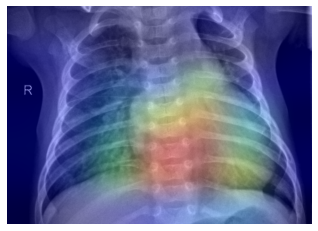

In [64]:
alpha, beta = 0.35, 0.7
superimp_c = heatmap_rsc * alpha + img/255 * beta
print(tf.reduce_min(superimp_c).numpy(), tf.reduce_max(superimp_c).numpy())
superimp_c = tf.cast(tf.clip_by_value(superimp_c * 255, 0.0, 255.0), tf.uint8)
tf.io.write_file('saliency-color.jpeg', tf.io.encode_jpeg(superimp_c))
plt.axis('off'); plt.imshow(superimp_c);